# simple validation model
the point of this notebook is to run a simple validation model to ensure what we put into RMS is what we expect. we will solve the reaction in RMS, and then by hand assuming a RLS. 

The mechanism is the degredation of Methanol to DME and water (problem 10-8), from 'Essentials of Chemical Reaction Engineering' by Fogler.

In [1]:
using ReactionMechanismSimulator
using PyPlot
using DifferentialEquations
using Sundials 
using YAML


## just analyze the baseline model for now

In [37]:
file_dir = "./simple_model.rms"
# file_dir = "./modified_rms.rms"
phaseDict = readinput(file_dir); #load mechanism dictionaryb

┌ Warning: failed to generate StokesDiffusivity model for species X
└ @ ReactionMechanismSimulator /work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/ReactionMechanismSimulator.jl/src/Parse.jl:316
┌ Warning: failed to generate StokesDiffusivity model for species H*
└ @ ReactionMechanismSimulator /work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/ReactionMechanismSimulator.jl/src/Parse.jl:316
┌ Warning: failed to generate StokesDiffusivity model for species O*
└ @ ReactionMechanismSimulator /work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/ReactionMechanismSimulator.jl/src/Parse.jl:316
┌ Warning: failed to generate StokesDiffusivity model for species OH*
└ @ ReactionMechanismSimulator /work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/ReactionMechanismSimulator.jl/src/Parse.jl:316
┌ Warning: failed to generate StokesDiffusivity model for species H2O*
└ @ ReactionMechanismSimulator /work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/ReactionMechani

### Initial Conditions

In [38]:
# convert volume flow to molar flow
r_si = 8.3145;
temp = 413; # [K]
press = 100*10^3; # [Pa], 100 kPa

# reactor: 
reac_vol = 4.5/1e-6; # [m^3], 4.3 cm^3
cat_weight = 1e-3; # [kg], 1 g 
cat_area = 1 # m^2, made up

# flow in 
volume_flow = 0.2/1e-6; # [m^3/s], 0.2 cm^3/s 
molar_flow = 2e-7 * press / (r_si * temp); # [mol/s]

In [39]:
gasspcs = phaseDict["gas"]["Species"]; # mechanism dictionaries index:  phaseDict[phasename]["Species" or "Reactions"]
gasrxns = phaseDict["gas"]["Reactions"];
surfacespcs = phaseDict["surface"]["Species"];
surfacerxns = phaseDict["surface"]["Reactions"];
interfacerxns = phaseDict[Set(["gas","surface"])]["Reactions"];

In [40]:
ig = IdealGas(gasspcs,gasrxns;name="gas"); #Define the phase (how species thermodynamic and kinetic properties calculated)
cat = IdealSurface(surfacespcs,surfacerxns,2.943e-5;name="surface");

In [41]:
initialcondsgas = Dict([
        "T"=>temp,
        "P"=>press,
        "CH3OH"=>1.0
        ]); #Set simulation Initial Temp and Pressure
# Define the domain (encodes how system thermodynamic properties calculated)
domaingas,y0gas,pgas = ConstantTPDomain(phase=ig,initialconds=initialcondsgas,sensitivity=true); 

In [42]:
V = reac_vol
A = cat_area
initialconds = Dict([
        "T"=>temp,
        "A"=>cat_area,
        "X"=>cat.sitedensity*A]); #Set simulation Initial Temp and Pressure
# Define the domain (encodes how system thermodynamic properties calculated)
domaincat,y0cat,pcat = ConstantTAPhiDomain(phase=cat,initialconds=initialconds,sensitivity=true);

## make reactor, inlet and outlet
- makes an anonymous function x->42, is that velocity in? need to check if it is velocity or volume flowrate
- also, I think the ```phi``` refers to chemical potential, but I should check, I think constantTPhi is just const T for our case. 

In [43]:
initialcondsinlet = Dict([
        "T"=>temp,
        "P"=>press,
        "CH3OH"=>1.0,
        ]);

# construct reactor
inter,pinter = ReactiveInternalInterfaceConstantTPhi(domaingas,domaincat,interfacerxns,initialcondsinlet["T"],A);

# make inlet and outlet
# should I specify molar flow for outlet?
inletgas = Inlet(domaingas,initialcondsinlet,x->molar_flow);
outletgas = Outlet(domaingas,x->molar_flow);

LoadError: MethodError: no method matching ReactiveInternalInterfaceConstantTPhi(::ConstantTPDomain{IdealGas{Tuple{Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Nothing}, Int64, Float64, Float64, Integer, Vector{Int64}}, ::ConstantTAPhiDomain{IdealSurface{Tuple{Arrheniusvec{Vector{Float64}, Vector{Float64}, Vector{Float64}}}, SparseArrays.SparseMatrixCSC{Float64, Int64}, Nothing, ReactionMechanismSimulator.NASAvec{EmptyThermoUncertainty}, Vector{Float64}}, Int64, Float64, Float64, Integer, Vector{Int64}}, ::Vector{ElementaryReaction{Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}, Int64, V1, V2, V3, V4, StaticArraysCore.SVector{1, StaticArraysCore.SVector{1, String}}} where {V1<:AbstractArray, V2<:AbstractArray, V3<:AbstractArray, V4<:AbstractArray}}, ::Matrix{Int64}, ::SparseArrays.SparseMatrixCSC{Float64, Int64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64}, ::Vector{Float64}, ::Float64, ::Int64, ::Vector{Int64}, ::Vector{Int64}, ::Vector{Float64}, ::Vector{Bool})
[0mClosest candidates are:
[0m  ReactiveInternalInterfaceConstantTPhi(::J, ::N, ::Vector{Q}, ::B, ::C, ::C2, ::C2, ::B2, ::B3, ::Float64, [91m::Float64[39m, ::Vector{Int64}, ::Vector{Int64}, ::Vector{Float64}, ::Vector{Bool}) where {J, N, B, B2, B3, C, C2, Q<:AbstractReaction} at /work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/ReactionMechanismSimulator.jl/src/Interface.jl:70
[0m  ReactiveInternalInterfaceConstantTPhi(::Any, ::Any, ::Any, ::Any, ::Any, ::Any) at /work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/ReactionMechanismSimulator.jl/src/Interface.jl:86
[0m  ReactiveInternalInterfaceConstantTPhi(::Any, ::Any, ::Any, ::Any, ::Any) at /work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/ReactionMechanismSimulator.jl/src/Interface.jl:86

lets break these apart one by one: 
### ```react,y0,p = Reactor(domains,(y0liq,y0gas),(0.0,tf),interfaces,(pcat,pgas,pinter));```
- react = reactor object, returned from Reactor() function call
- y0 = initial values of all mole fractions, plus last index is... Temperature? 
- p - phases? 

In [9]:
# Define domains and interfaces
domains = (domaingas,domaincat)
interfaces = [inter,inletgas,outletgas]

# create a reactor for the system
react,y0,p = Reactor(domains,(y0gas,y0cat),(0.0,100),interfaces,(pgas,pcat,pinter)); # Create the reactor object
sol = solve(react.ode,react.recommendedsolver,abstol=1e-18,reltol=1e-6);

LoadError: UndefVarError: inter not defined

In [10]:
ssys = SystemSimulation(sol,domains,interfaces,p);

LoadError: UndefVarError: sol not defined

In [11]:
methods(SystemSimulation)

# 2 methods for type constructor:
[1] SystemSimulation(sol::B, sims::Q, interfaces::X, names::Vector{String}, species::Vector{Z}, reactions::Vector{Y}, p::Vector{Float64}) where {Q, B<:SciMLBase.AbstractODESolution, X, Y, Z} in ReactionMechanismSimulator at /work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/ReactionMechanismSimulator.jl/src/Simulation.jl:90
[2] SystemSimulation(sol, domains, interfaces, p) in ReactionMechanismSimulator at /work/westgroup/ChrisB/_01_MeOH_repos/uncertainty_analysis/ReactionMechanismSimulator.jl/src/Simulation.jl:113

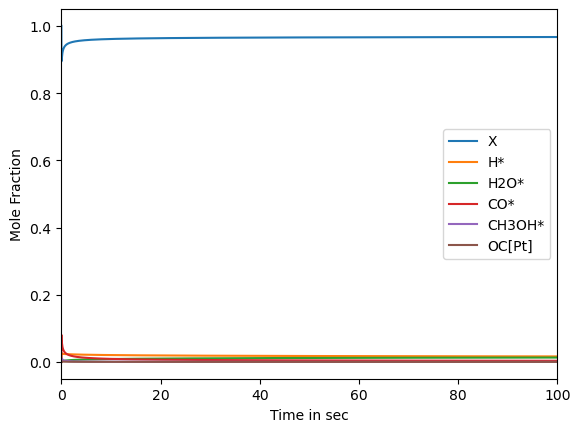

(0.0, 100.0)

In [17]:
plotmolefractions(ssys.sims[2],tol=0.001)
xlim(0.0,100)

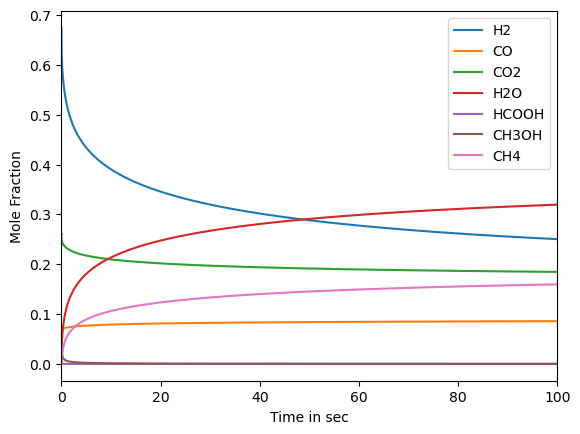

(0.0, 100.0)

In [18]:
plotmolefractions(ssys.sims[1];exclude=["N2"],tol=0.000001)
xlim(0.0,100)

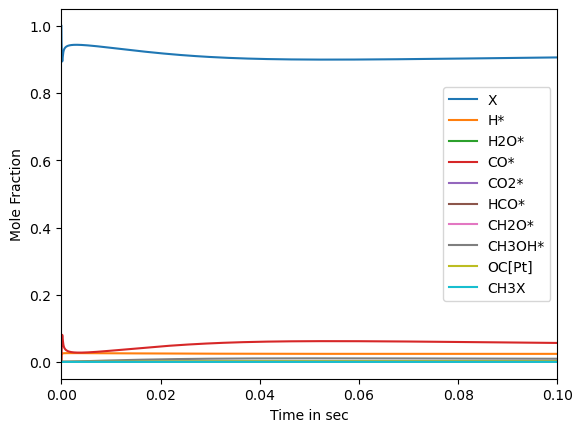

(0.0, 0.1)

In [19]:
plotmolefractions(ssys.sims[2];exclude=["N2"],tol=0.000001)
xlim(0.0,0.1 )

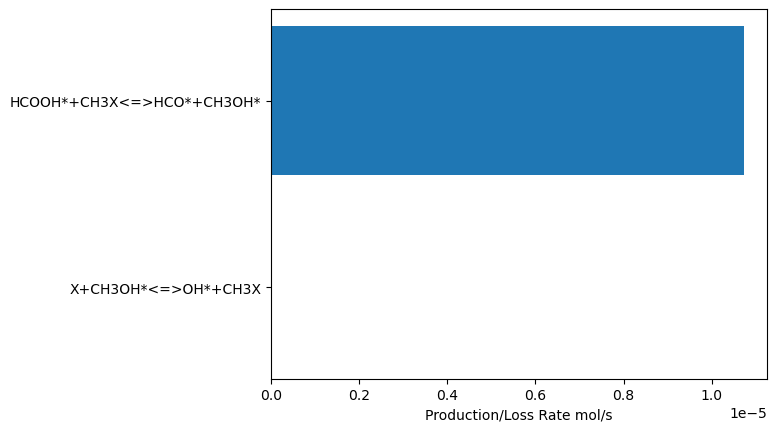

In [20]:
plotrops(ssys.sims[2],"CH3X",0.0001)

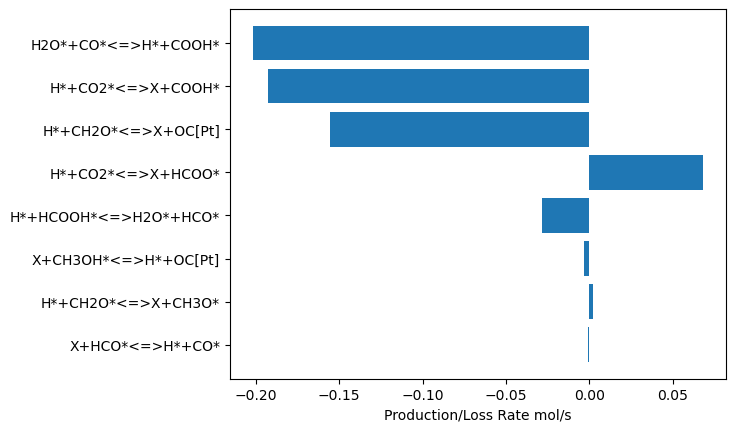

In [21]:
plotrops(ssys.sims[2],"H*",0.1)

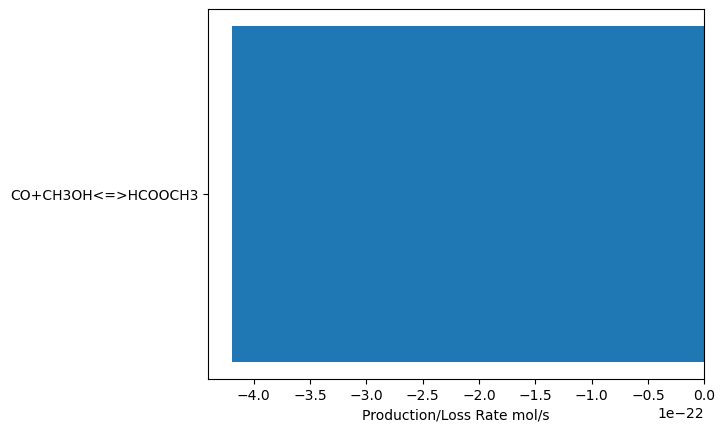

In [22]:
plotrops(ssys.sims[1],"CH3OH",1e-1)

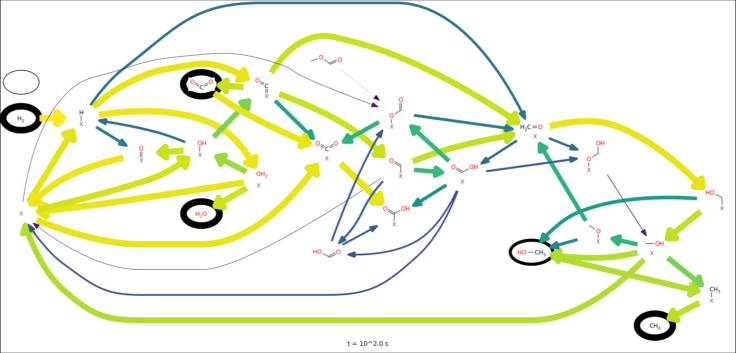

In [23]:
getfluxdiagram(ssys,100)

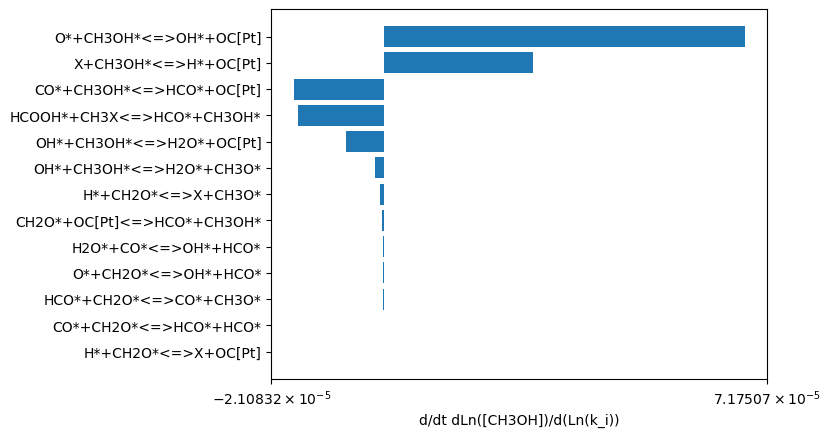

In [24]:
plotrxntransitorysensitivities(ssys, "CH3OH", 100)

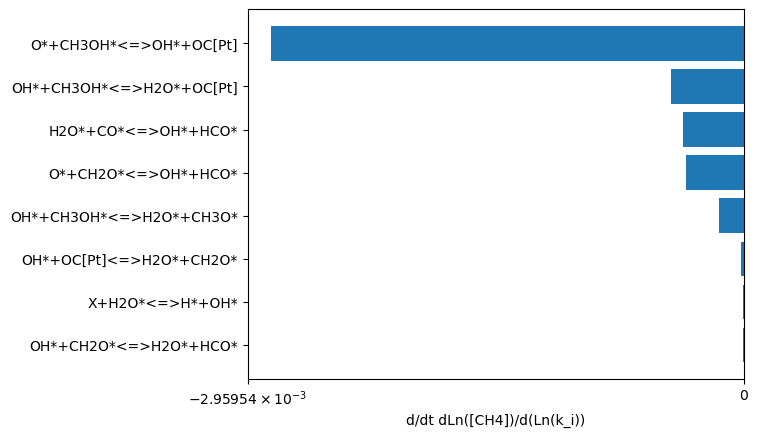

In [25]:
plotrxntransitorysensitivities(ssys, "CH4", 1)

In [26]:
rms_yaml = YAML.load_file(file_dir);

In [27]:
rms_yaml_copy = deepcopy(rms_yaml)

Dict{Any, Any} with 4 entries:
  "Units"      => Dict{Any, Any}()
  "Interfaces" => Dict{Any, Any}[Dict()]
  "Reactions"  => Dict{Any, Any}[Dict("reactants"=>["X", "X", "H2"], "products"…
  "Phases"     => Dict{Any, Any}[Dict("name"=>"gas", "Species"=>Dict{Any, Any}[…

In [49]:


for (index, rxn) in enumerate(rms_yaml["Reactions"])
    if "CH3OH*" in rxn["reactants"] && "CH2O*" in rxn["reactants"]
        if "CH3X" in rxn["products"] && "CH3O2*" in rxn["products"]
            rms_yaml_copy["Reactions"] = deleteat!(rms_yaml["Reactions"], index)
            print(rxn)
        end
    end
end

Dict{Any, Any}("reactants" => ["CH2O*", "CH3OH*"], "products" => ["CH3X", "CH3O2*"], "kinetics" => Dict{Any, Any}("Ea" => 26684.02703783661, "A" => 3.2e17, "type" => "Arrhenius", "n" => 0.0), "radicalchange" => 0, "type" => "ElementaryReaction")

In [50]:
YAML.write_file("modified_rms.rms", rms_yaml_copy)

### get rxns that have reactants and products of most sensitive reactions

In [30]:
for rxn in ssys.reactions
    for reac in rxn.reactants
        if "CH3OH*" == reac.name
            println(rxn.index)
        end
    end
    for prod in rxn.products
        if "CO" == prod.name
            println(rxn.index)
        end
    end
end

20
25
36
37
49
50
52
62
94
96
98
100
114
118
119
121
122
123
6


## getting "follow" to work for CO2/CO 

In [31]:
sim = ssys.sims[1]
t = 0.01
rop = rops(sim,t)
ropp = zeros(size(rop))
for i in eachindex(rop)
    if rop[i] > 0
        ropp[i] = rop[i]
    end
end
ropl = zeros(size(rop))
for i in eachindex(rop)
    if rop[i] < 0
        ropl[i] = abs(rop[i])
    end
end
rts = rates(sim,t)

7-element Vector{Float64}:
  4.394456559694548e-30
 -4.4114808121326415e-21
 -6.042034352296424e-25
  9.332900614484244e-23
 -6.042034352296424e-25
 -6.042034352296424e-25
 -4.9047728287951007e-20

In [32]:
path = follow(ssys,135,9,ropp,ropl,rts,true;steptol=1e-2,branchtol=5e-2)
path.branchfracts

Float64[]

In [33]:
fieldnames(typeof(path))

(:forward, :spcsinds, :rxninds, :spcind, :branchfracts, :branchfract, :branchind)

In [34]:
plotrxntransitorysensitivities(ssys.sims[1], "CH3OH", 0.01)

LoadError: BoundsError: attempt to access 7-element Vector{Float64} at index [22]

In [35]:
obj = ssys.reactions[1]
# print(typeof(obj))
fieldnames(typeof(obj))


(:index, :reactants, :reactantinds, :products, :productinds, :kinetics, :electronchange, :radicalchange, :reversible, :pairs)

In [36]:
obj.kinetics

Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}
  A: Float64 2890.0000000000005
  n: Float64 1.16
  Ea: Float64 343506.0
  unc: EmptyRateUncertainty EmptyRateUncertainty()


In [37]:
obj[2].smiles

LoadError: MethodError: no method matching getindex(::ElementaryReaction{Arrhenius{Float64, Float64, Float64, EmptyRateUncertainty}, Int64, StaticArraysCore.SVector{2, Species{NASA{EmptyThermoUncertainty}, StokesDiffusivity{Float64}, EmptyHenryLawConstant, EmptyLiquidVolumetricMassTransferCoefficient}}, StaticArraysCore.MVector{2, Int64}, StaticArraysCore.SVector{1, Species{NASA{EmptyThermoUncertainty}, StokesDiffusivity{Float64}, EmptyHenryLawConstant, EmptyLiquidVolumetricMassTransferCoefficient}}, StaticArraysCore.MVector{1, Int64}, StaticArraysCore.SVector{1, StaticArraysCore.SVector{1, String}}}, ::Int64)

In [38]:
for rxn in ssys.reactions
    for reac in rxn.reactants
        if "CO" == reac.name
            println(rxn.index)
        end
    end
    for prod in rxn.products
        if "CO" == prod.name
            println(rxn.index)
        end
    end
end

1
2
4
6


In [39]:

for index in 1:length(ssys.reactions)
    for reac in ssys.reactions[index].reactants
        if "CO" == reac.name
            print("!",index, "!") 
        end
        print(reac.name, " ")
    end
    print("<=> ")
    for prod in ssys.reactions[index].products
        if "CO" == prod.name
            print("!",index, "!")
        end
        print(prod.name, " ")
    end
    print("\n")
end

H2 !1!CO <=> CH2O 
H2O !2!CO <=> HCOOH 
H2 CO2 <=> HCOOH 
!4!CO CH3OH <=> HCOOCH3 
H2 CO2 <=> HCOOH 
H2 CO2 <=> HCOOH 
CO2 CH4 <=> HCOOCH3 
X OH* <=> O* H* 
X H2O* <=> H* OH* 
O* H2O* <=> OH* OH* 
O* CO* <=> X CO2* 
OH* CO* <=> H* CO2* 
HCOO* <=> COOH* 
X HCO* <=> H* CO* 
H* CO2* <=> X HCOO* 
X HCOO* <=> O* HCO* 
H* CO2* <=> X COOH* 
X COOH* <=> OH* CO* 
X HCOOH* <=> OH* HCO* 
X HCOOH* <=> H* HCOO* 
X HCOOH* <=> OH* HCO* 
X HCOOH* <=> H* COOH* 
X CH2O* <=> H* HCO* 
H* CH2O* <=> X CH3O* 
OH* CH2O* <=> X CH3O2* 
H* HCOOH* <=> X CH3O2* 
X CH3OH* <=> H* CH3O* 
O* CH2O* <=> H* HCOO* 
H2O* CO* <=> H* COOH* 
OH* CH2O* <=> H* HCOOH* 
H* HCOOH* <=> H2O* HCO* 
O* CH3OH* <=> H* CH3O2* 
H2O* CH2O* <=> H* CH3O2* 
O* HCO* <=> OH* CO* 
OH* CO2* <=> O* HCOO* 
OH* CO2* <=> O* COOH* 
O* HCOOH* <=> OH* HCOO* 
O* HCOOH* <=> OH* HCOO* 
O* HCOOH* <=> OH* COOH* 
O* CH2O* <=> OH* HCO* 
OH* CH2O* <=> O* CH3O* 
OH* HCOOH* <=> O* CH3O2* 
O* CH3OH* <=> OH* CH3O* 
O* CH3OH* <=> OH* CH3O* 
H2O* CO* <=> OH* HCO* 
X 

In [40]:
fieldnames(typeof(ssys.reactions[1].reactants[1]))


(:name, :index, :inchi, :smiles, :adjlist, :thermo, :atomnums, :bondnum, :diffusion, :radius, :radicalelectrons, :molecularweight, :henrylawconstant, :liquidvolumetricmasstransfercoefficient)

In [41]:
for spec in ssys.species
    println(spec.index, ":", spec.name, ": ", spec.smiles)
end

1:N2: N#N
2:Ne: [Ne]
3:H2: [H][H]
4:CO: [C-]#[O+]
5:CO2: O=C=O
6:H2O: O
7:CH2O: C=O
8:HCOOH: O=CO
9:CH3OH: CO
10:HCOOCH3: COC=O
11:CH4: C
1:X: [Pt]
2:H*: [Pt]
3:O*: O=[Pt]
4:OH*: O[Pt]
5:H2O*: O.[Pt]
6:CO*: O=C=[Pt]
7:CO2*: O=C=O.[Pt]
8:HCO*: O=C[Pt]
9:HCOO*: O=CO[Pt]
10:COOH*: O=C(O)[Pt]
11:HCOOH*: O=CO.[Pt]
12:CH2O*: C=O.[Pt]
13:CH3O*: CO[Pt]
14:CH3O2*: OCO[Pt]
15:CH3OH*: CO.[Pt]
16:OC[Pt]: OC[Pt]
17:CH3X: C[Pt]
